<a href="https://colab.research.google.com/github/guylozius/Classification-of-Edible-and-Poisonous-Mushrooms/blob/main/Classification_of_Edible_and_Poisonous_Mushrooms_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#Mushroom Dataset

Source of data: https://www.kaggle.com/datasets/uciml/mushroom-classification

- Description: The dataset shows different feature of a list mushroom. 

- Target: Is it poisonous(class column)

- This a classification  problem

- There are  8124 rows and 23 columns.

- The dataset is from a hypothetical samples, so I do not know,<br/> if it
will be a good prediction on other dataset similar to it.



In [ ]:
pd.set_option('display.max_column',None)
mushroom_df = pd.read_csv('/content/drive/MyDrive/coding dojo/stack_two/Project 2/mushrooms.csv')
mushroom_df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


# Cleaning Dataset

### Checking Duplicated values

In [ ]:
#checking for duplicated values
mushroom_df.duplicated().sum()

0

>There no duplicted values 

## Checking for missing value

In [ ]:
# Using isna() to find missing value
mushroom_df.isna().sum().any()

False

> According to isna() there are no missing values.

In [ ]:
#checking all the value in each columns

for col in mushroom_df.columns:
  print(f'{col}:')
  print(mushroom_df[col].value_counts())
  print('\n\n')

class:
e    4208
p    3916
Name: class, dtype: int64



cap-shape:
x    3656
f    3152
k     828
b     452
s      32
c       4
Name: cap-shape, dtype: int64



cap-surface:
y    3244
s    2556
f    2320
g       4
Name: cap-surface, dtype: int64



cap-color:
n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
u      16
r      16
Name: cap-color, dtype: int64



bruises:
f    4748
t    3376
Name: bruises, dtype: int64



odor:
n    3528
f    2160
y     576
s     576
a     400
l     400
p     256
c     192
m      36
Name: odor, dtype: int64



gill-attachment:
f    7914
a     210
Name: gill-attachment, dtype: int64



gill-spacing:
c    6812
w    1312
Name: gill-spacing, dtype: int64



gill-size:
b    5612
n    2512
Name: gill-size, dtype: int64



gill-color:
b    1728
p    1492
w    1202
n    1048
g     752
h     732
u     492
k     408
e      96
y      86
o      64
r      24
Name: gill-color, dtype: int64



stalk-shape:
t    4608
e    3516
Name: stalk-sha

>The stalk-root column have value "?" I will replace with "Unknown"

In [ ]:
# Replacing "?" with "Unknown"
mushroom_df.replace("?","Unknown", inplace=True)

### Changing value in column

> Changing value to full word instead of the abbreviation, so it is easier to understand.

In [ ]:
#Making dict for the full words
new_word = {'class':{'e':'edible', 'p':'poisonous'},
            'cap-shape':{'b':'bell','c':'conical','x':'convex','f':'flat','k':'knobbed', 's':'sunken'},
            'cap-surface':{'f':'fibrous','g':'grooves','y':'scaly','s':'smooth'},
            'cap-color':{'n':'brown','b':'buff','c':'cinnamon','g':'gray','r':'green','p':'pink','u':'purple','e':'red','w':'white','y':'yellow','o':'orange'},
            'bruises':{'t':'true','f':'false'},
            'odor':{'a':'almond','l':'anise','c':'creosote','y':'fishy','f':'foul','m':'musty','n':'none','p':'pungent','s':'spicy'},
            'gill-attachment':{'a':'attached','d':'descending','f':'free','n':'notched'},
            'gill-spacing':{'c':'close','w':'crowded','d':'distant'},
            'gill-size':{'b':'broad', 'n':'narrow'},
            'gill-color':{'k':'black','n':'brown','b':'buff','h':'chocolate','g':'gray','r':'green','o':'orange','u':'purple','p':'pink','w':'white','y':'yellow'},
            'stalk-shape':{'e':'enlarging','t':'tapering'},
            'stalk-root':{'b':'bulbous','c':'club','u':'cup','e':'equal','z':'rhizomorphs','r':'rooted'},
            'stalk-surface-above-ring':{'f':'fibrous','y':'scaly','k':'siky','s':'smooth'},
            'stalk-surface-below-ring':{'f':'fibrous','y':'scaly','k':'siky','s':'smooth'},
            'stalk-color-above-ring':{'n':'brown','b':'buff','c':'cinnamon','g':'gray','r':'green','p':'pink','u':'purple','e':'red','w':'white','y':'yellow','o':'orange'},
            'stalk-color-below-ring':{'n':'brown','b':'buff','c':'cinnamon','g':'gray','r':'green','p':'pink','u':'purple','e':'red','w':'white','y':'yellow','o':'orange'},
            'veil-type':{'p':'partial','u':'universal'},
            'veil-color':{'n':'brown','w':'white','y':'yellow','o':'orange=o'},
            'ring-number':{'n':'none','o':'one','t':'two'},
            'ring-type':{'c':'cobwebby','e':'evanescent','f':'flaring','l':'large','n':'none','p':'pendant','sheathing':'s','z':'zone'},
            'spore-print-color':{'k':'black','n':'brown','b':'buff','h':'chocolate','r':'green','o':'orange','u':'purple','w':'white','y':'yellow'},
            'population':{'a':'abundant','c':'clustered','n':'numerous','s':'scattered','v':'several','y':'solitary'},
            'habitat':{'g':'grasses','l':'leaves','m':'meadows','p':'paths','u':'urban','w':'waste','d':'woods'}}

In [ ]:
#replacing abbreviation to full words
mushroom_df.replace(new_word,inplace=True)
mushroom_df.head(10)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,true,pungent,free,close,narrow,black,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,true,almond,free,close,broad,black,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,true,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,true,pungent,free,close,narrow,brown,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,false,none,free,crowded,broad,black,tapering,equal,smooth,smooth,white,white,partial,white,one,evanescent,brown,abundant,grasses
5,edible,convex,scaly,yellow,true,almond,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,black,numerous,grasses
6,edible,bell,smooth,white,true,almond,free,close,broad,gray,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,black,numerous,meadows
7,edible,bell,scaly,white,true,anise,free,close,broad,brown,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,brown,scattered,meadows
8,poisonous,convex,scaly,white,true,pungent,free,close,narrow,pink,enlarging,equal,smooth,smooth,white,white,partial,white,one,pendant,black,several,grasses
9,edible,bell,smooth,yellow,true,almond,free,close,broad,gray,enlarging,club,smooth,smooth,white,white,partial,white,one,pendant,black,scattered,meadows


# Data Exploration

In [ ]:
"""A function  that plots three plots one is barplot for most frequent, and other on is barplot too  for 
   most frequent group by the class column and last boxplot of the most frequent. """
def plot_maker(col):
  fig, (ax1,ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize=(8,4));
  mushroom_df[col].value_counts().plot.bar( ax=ax1)
  mushroom_df.groupby(['class'])[col].value_counts().plot.bar( ax=ax2)
  ax1.set_title(f'Most frequency values in {col} column')
  ax1.tick_params(labelsize=15)
  ax2.set_title(f'Frequency values in {col} column groupby Class ')
  ax2.tick_params(labelsize=15)
  mushroom_df[col].value_counts().plot.box(ax=ax3)
  ax3.set_title(f'Most frequency values in {col} column boxplot')
  for index,data in enumerate(mushroom_df[col].value_counts()):
    ax1.text(x=index-0.15 , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=12))
  for index,data in enumerate(mushroom_df.groupby(['class'])[col].value_counts()):
    ax2.text(x=index-0.15 , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=12))
  plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1.7,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
  plt.show()

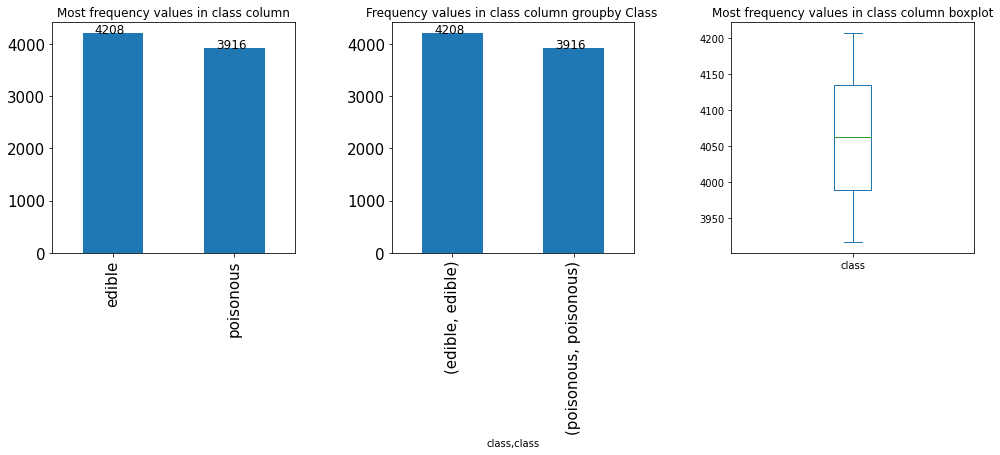

In [ ]:
plot_maker('class')

> The target is balance.

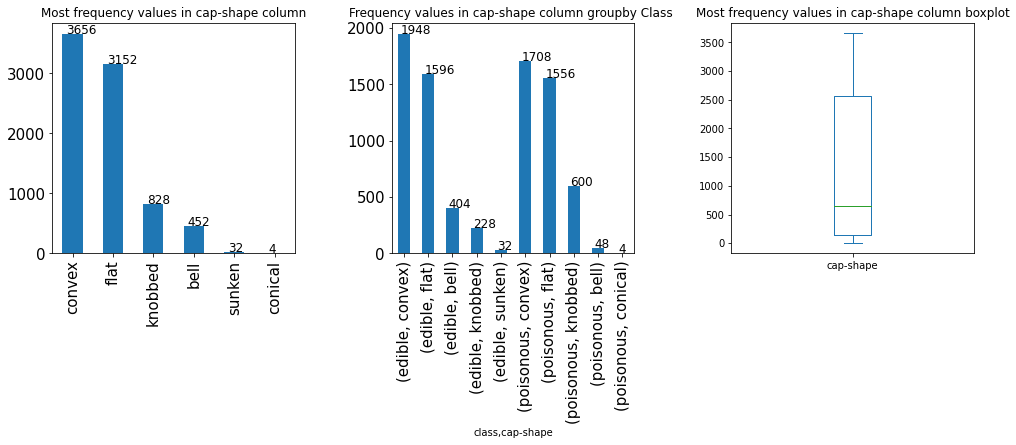

In [ ]:
plot_maker('cap-shape')

> The convex is most frequency value and corical is least frequency. <br/>
The values are evenly distribute between edible and poisonous.<br/>



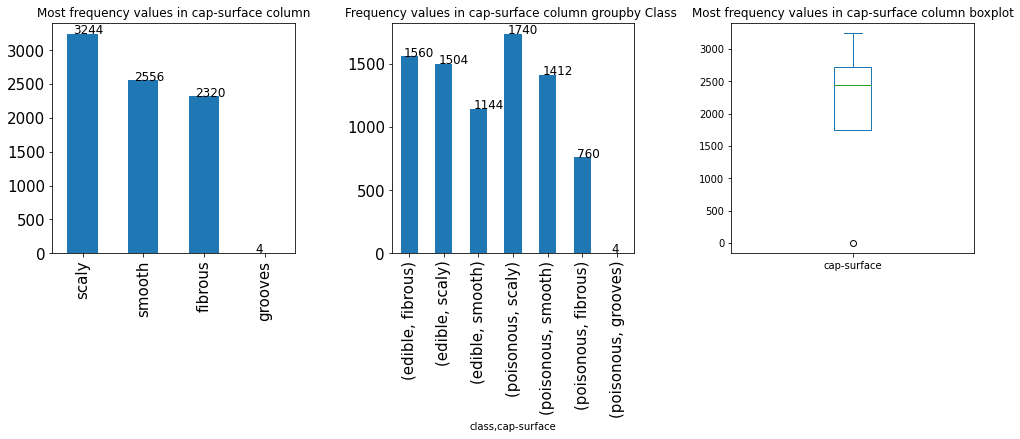

In [ ]:
plot_maker('cap-surface')

>The scaly is most frequency value and grooves is least frequency. <br/>
The values are evenly distribute between edible and poisonous.<br/>
grooves maybe outlier.

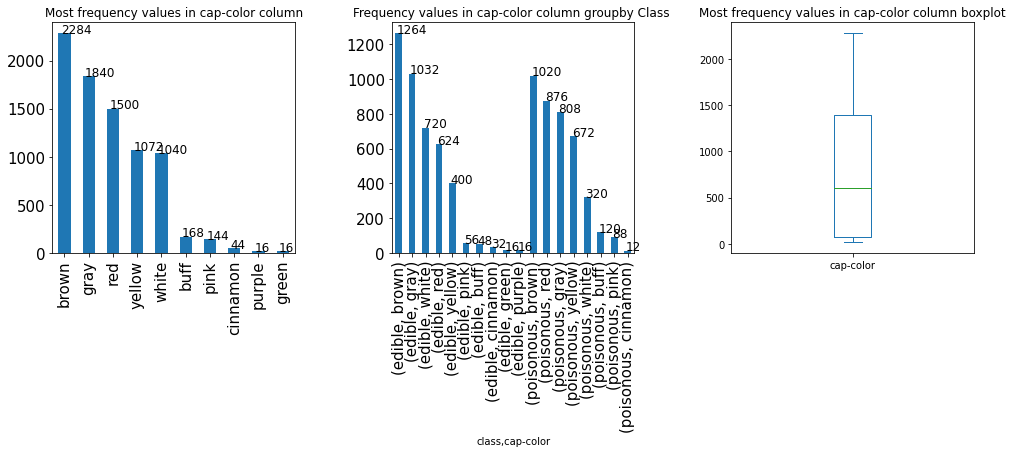

In [ ]:
plot_maker('cap-color')

>The brown is most frequency value and green and pink are least frequency. <br/>
The values are evenly distribute between edible and poisonous.<br/>

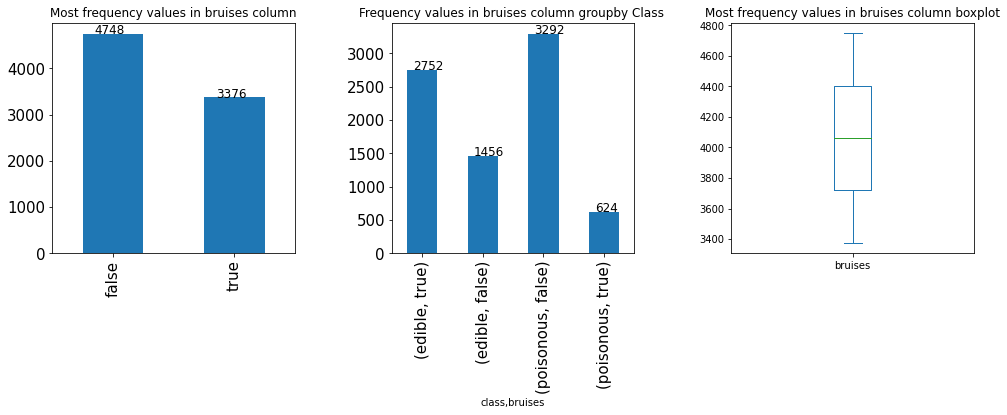

In [ ]:
plot_maker('bruises')

>The No bruises is most frequency and bruises is least frequency. <br/>
The values are evenly distribute between edible and poisonous.<br/>

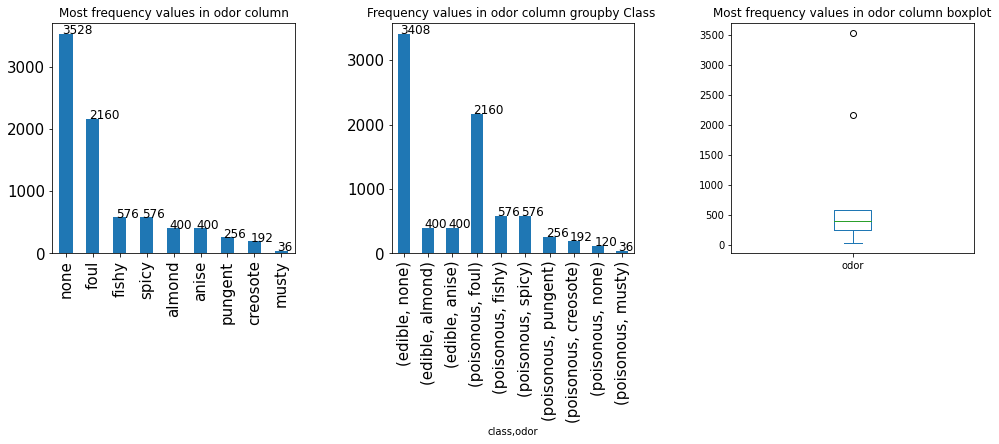

In [ ]:
plot_maker('odor')

>The No smell is most frequency and musty is least frequency. <br/>
The No ,almond, and anise are edibel while the other are not.<br/>
None and foul are outliers according to boxplot.

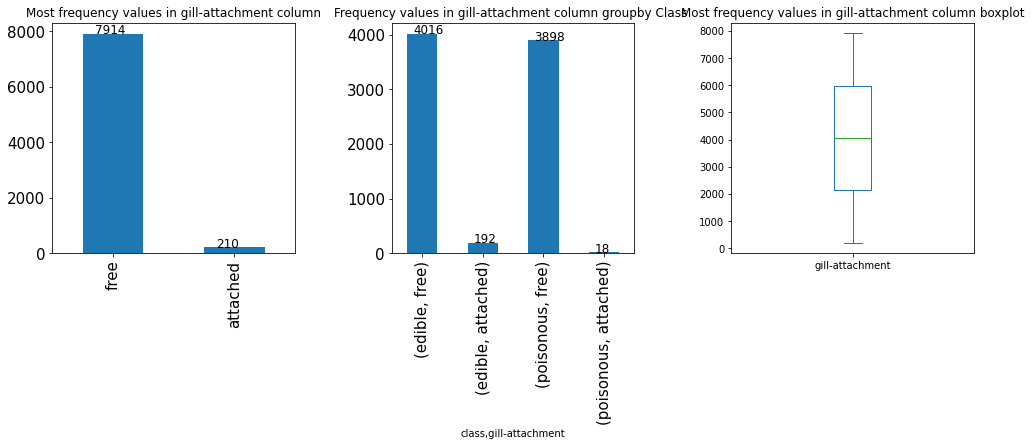

In [ ]:
plot_maker('gill-attachment')

>The free gill is most frequency and attached gill is least frequency.<br/>
The values are evenly distribute between edible and poisonous.

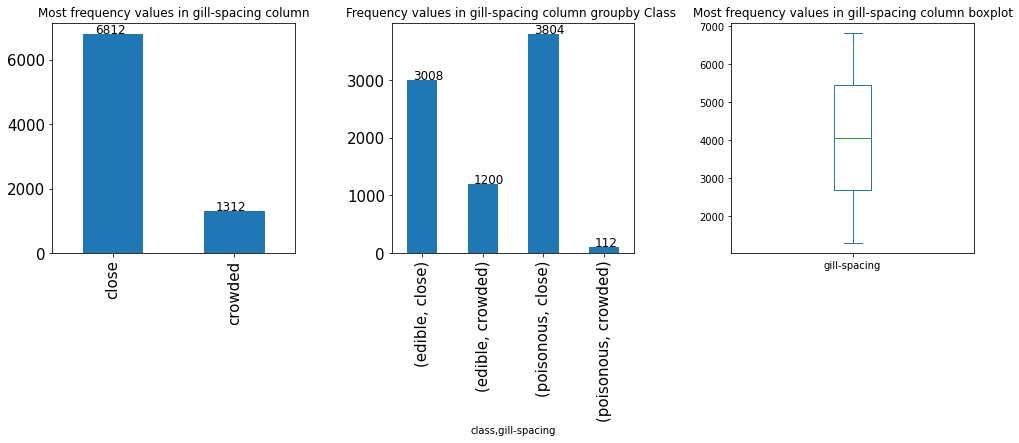

In [ ]:
plot_maker('gill-spacing')

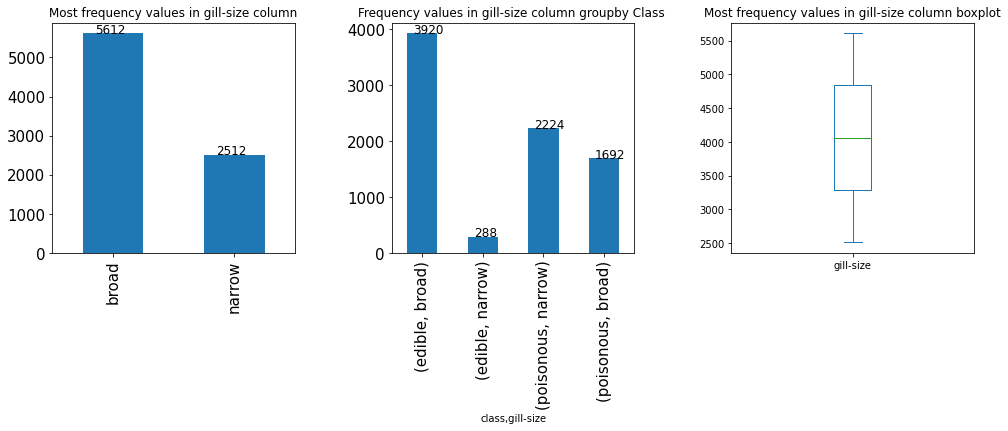

In [ ]:
plot_maker('gill-size')

>The broad size gill is most frequency and narrow size gill is least frequency.<br/>
>The values are evenly distribute between edible and poisonous.

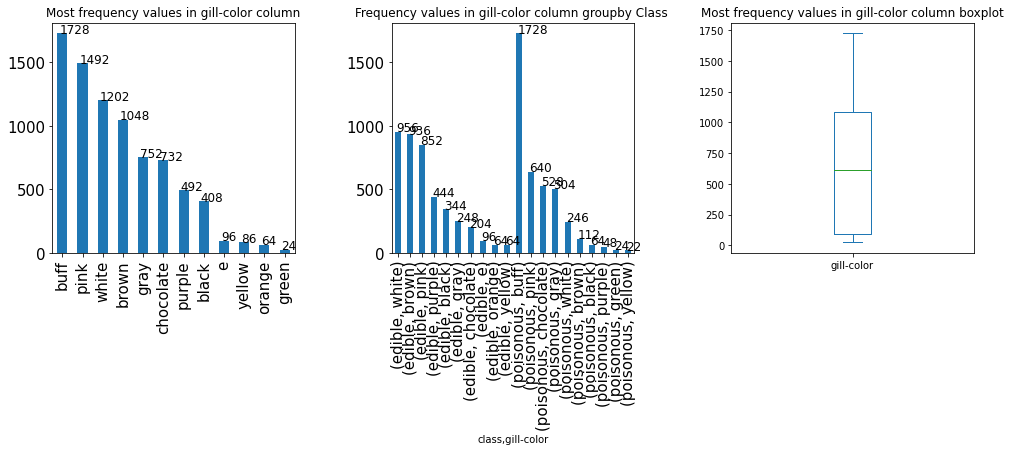

In [ ]:
plot_maker('gill-color')

>The buff is most frequency and green is least frequency.<br/>
The values are evenly distribute between edible and poisonous, but all of the buff gill are poisonous.

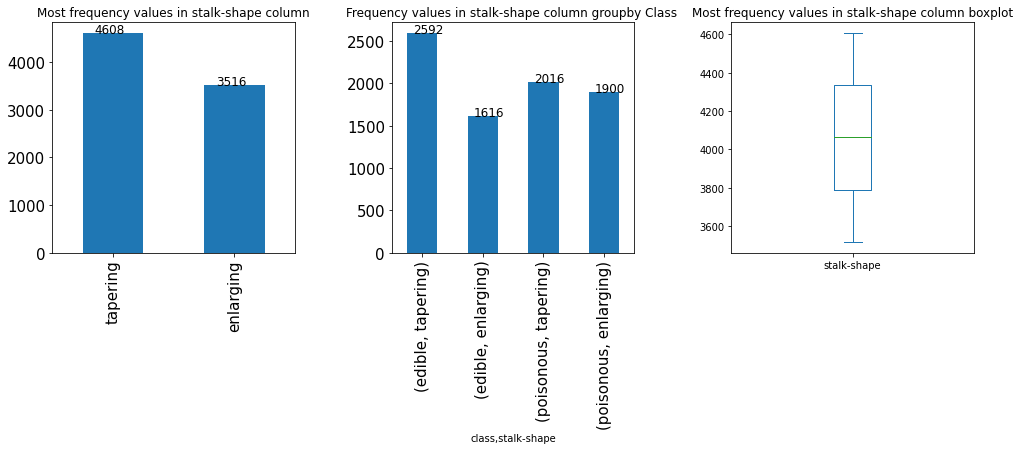

In [ ]:
plot_maker('stalk-shape')

>The trapering is most frequency and enlarging is least frequency.<br/>
The values are evenly distribute between edible and poisonous.

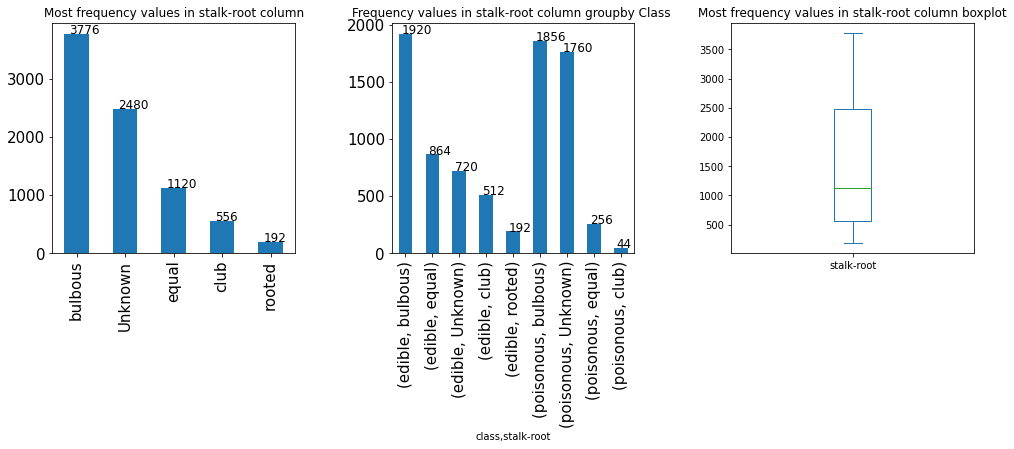

In [ ]:
plot_maker('stalk-root')

>The bulbous is most frequency and rooted is least frequency.<br/>
The values are evenly distribute between edible and poisonous.

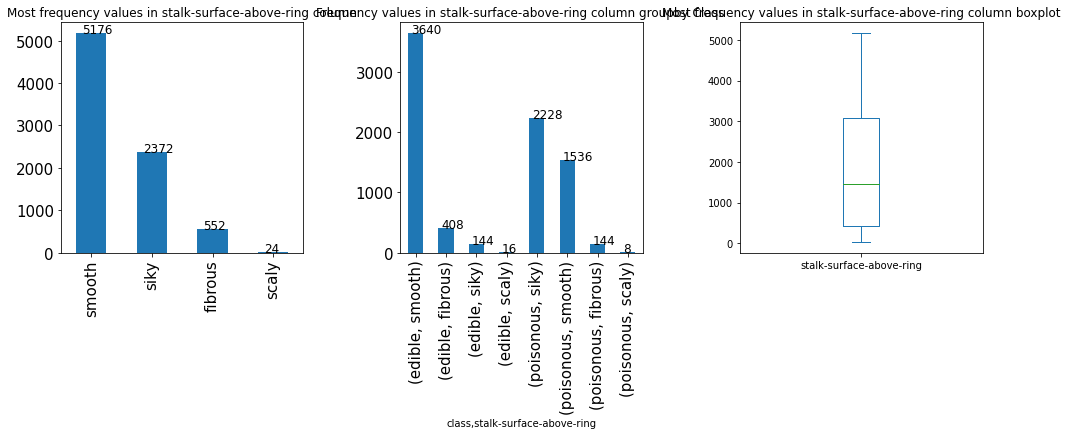

In [ ]:
plot_maker('stalk-surface-above-ring')

>The smooth is most frequency and scaly is least frequency.<br/>
The values are evenly distribute between edible and poisonous.

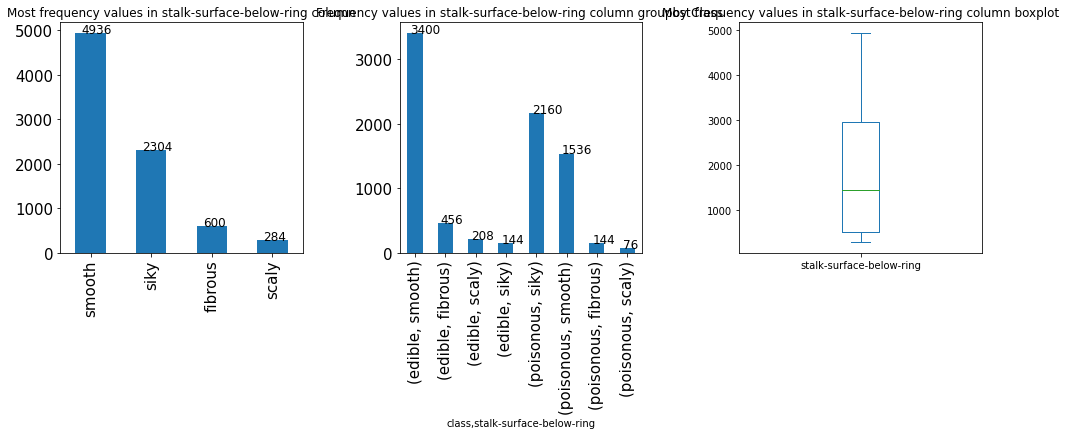

In [ ]:
plot_maker('stalk-surface-below-ring')

>The smooth is most frequency and scaly is least frequency.<br/>
The values are evenly distribute between edible and poisonous.

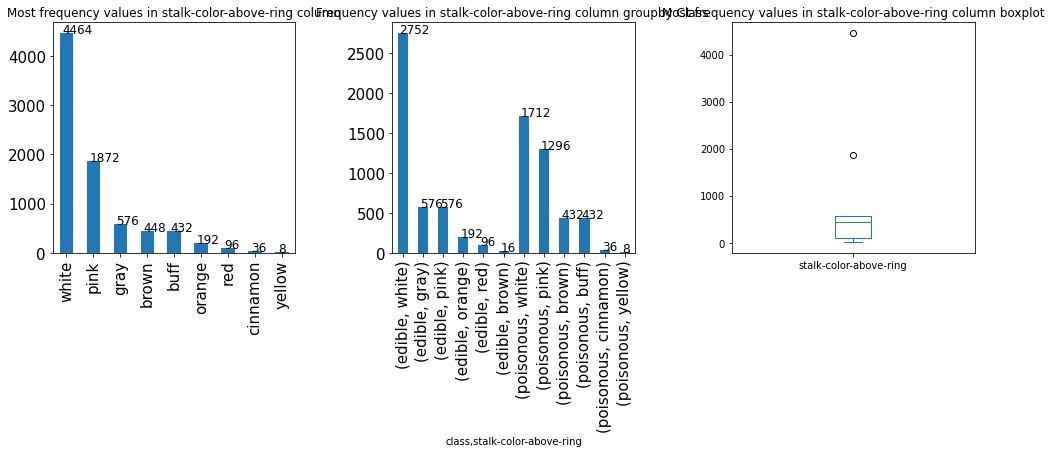

In [ ]:
plot_maker('stalk-color-above-ring')

>The white is most frequency and yellow is least frequency.<br/>
The values are evenly distribute between edible and poisonous.<br/>
white and pink are outliers according to boxplot.

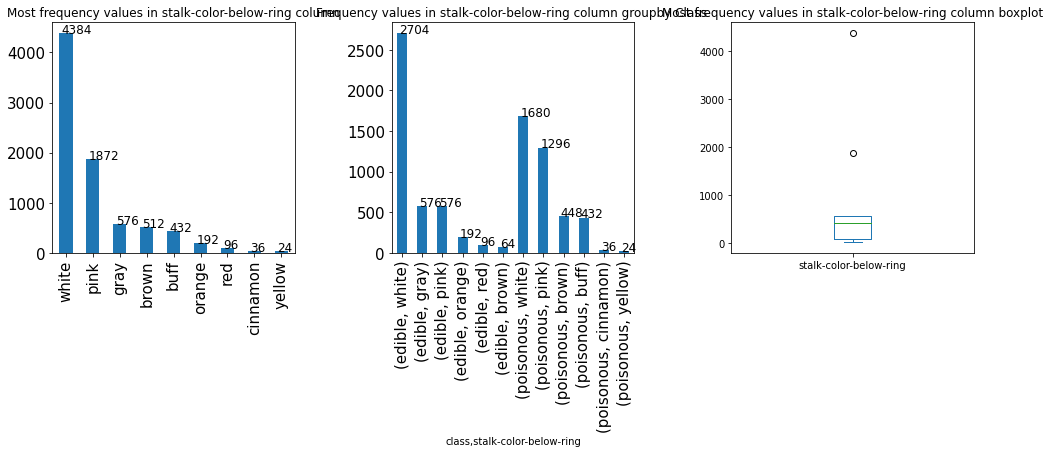

In [ ]:
plot_maker('stalk-color-below-ring')

>The white is most frequency and yellow is least frequency.<br/>
The values are evenly distribute between edible and poisonous.<br/>
white and pink are outliers according to boxplot.

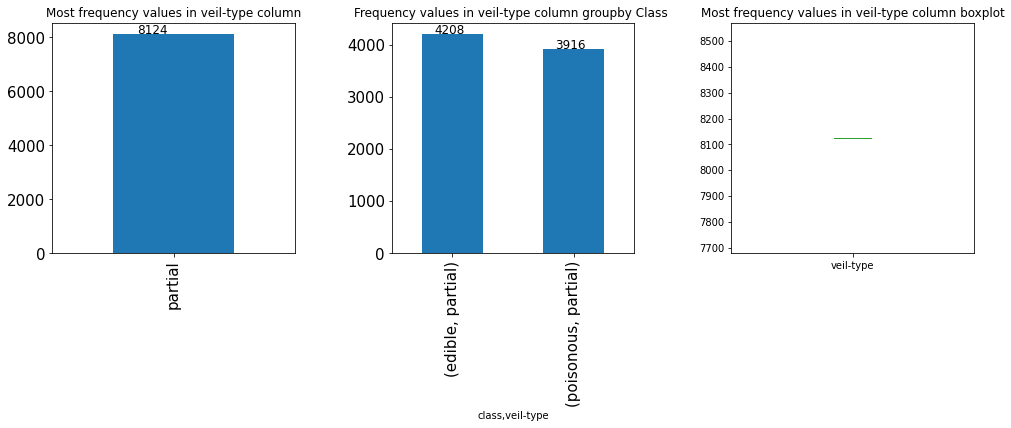

In [ ]:
plot_maker('veil-type')

>Partial is only values and split evenly between edible and poisonous.
<br/>Planning on drop this column because it have one value.

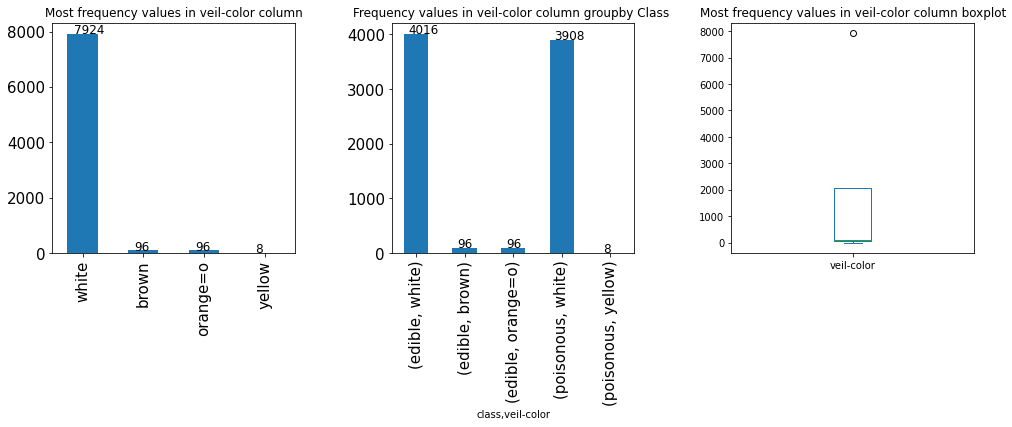

In [ ]:
plot_maker('veil-color')


>The white is most frequency and yellow is least frequency.<br/>
The white is evenly distribute between edible and poisonous the other colors are not this might because of same sample size though.<br/>
White is is a outlier according to boxplot.

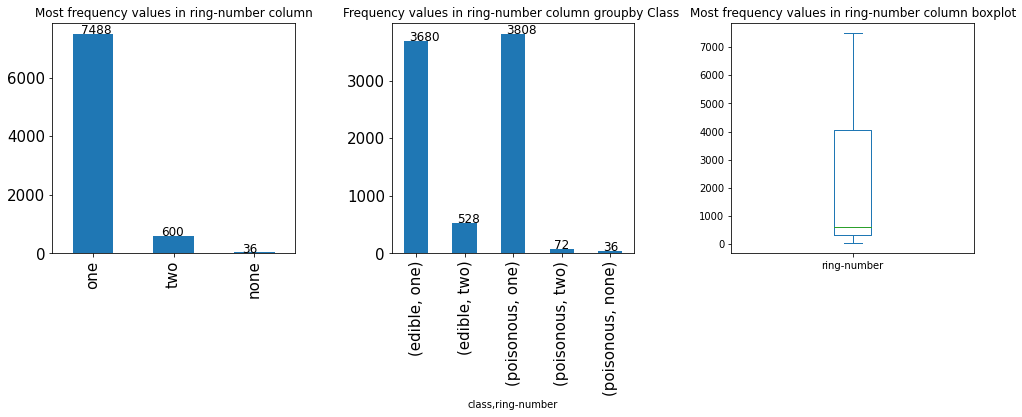

In [ ]:
plot_maker('ring-number')

The one is most frequency and noneis least frequency.<br/>
The one is evenly distribute between edible and poisonous the other values are not this might because of same sample size though.

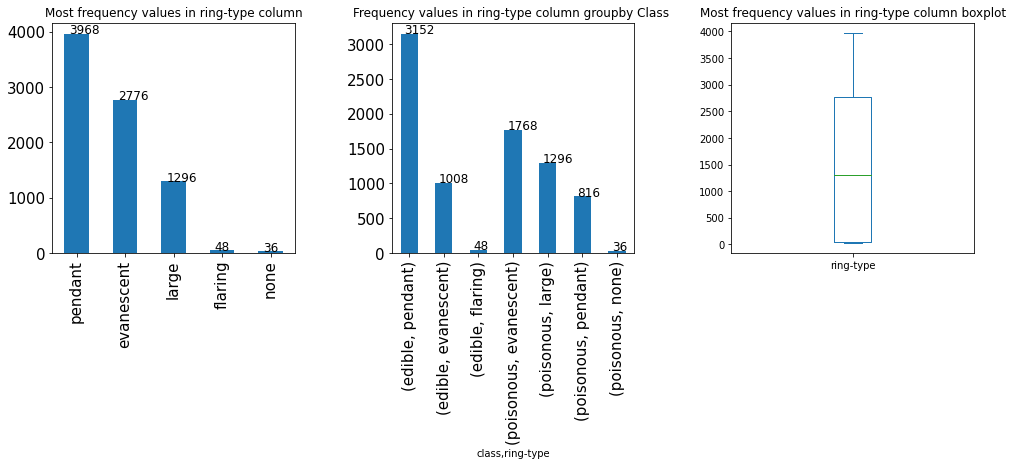

In [ ]:
plot_maker('ring-type')

The peadant is most frequency and none is least frequency.<br/>
All of the pendant are poisonous.

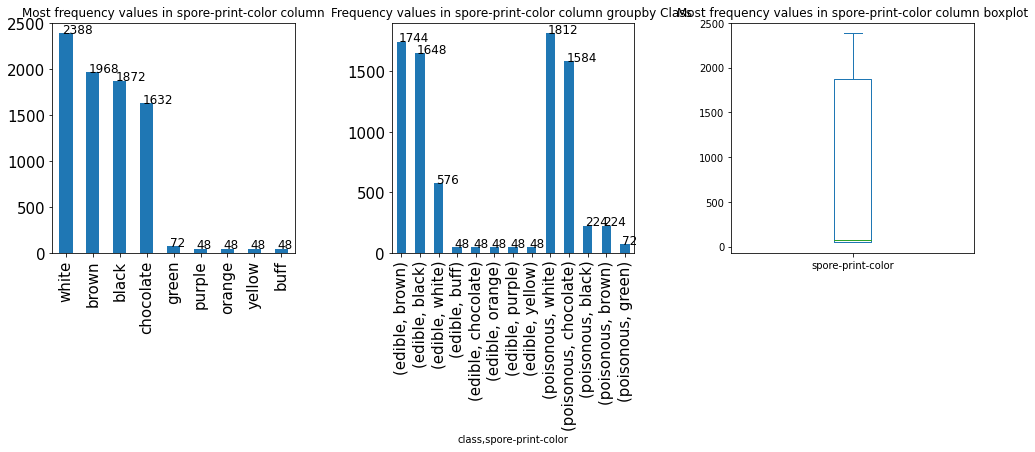

In [ ]:
plot_maker('spore-print-color')

The white is most frequency and buff is least frequency.<br/>
buff, chocolate, orange, purple, yellow are edible and rest are distribute beteewn the two classes.

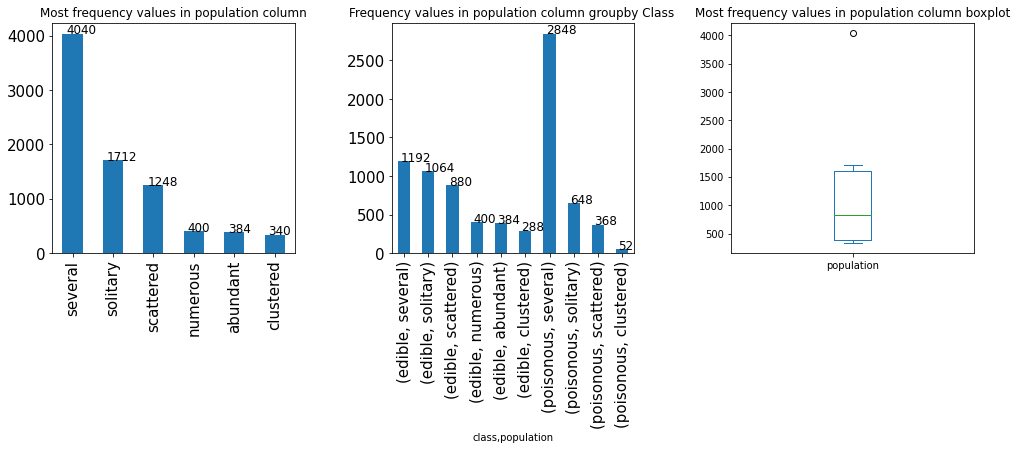

In [ ]:
plot_maker('population')

The several is most frequency and clustered is least frequency.<br/>
Numerou and abundant are all edible, but rest is enve distribute beteewn the two classes.<br/>
several is a outliers according to boxplot.

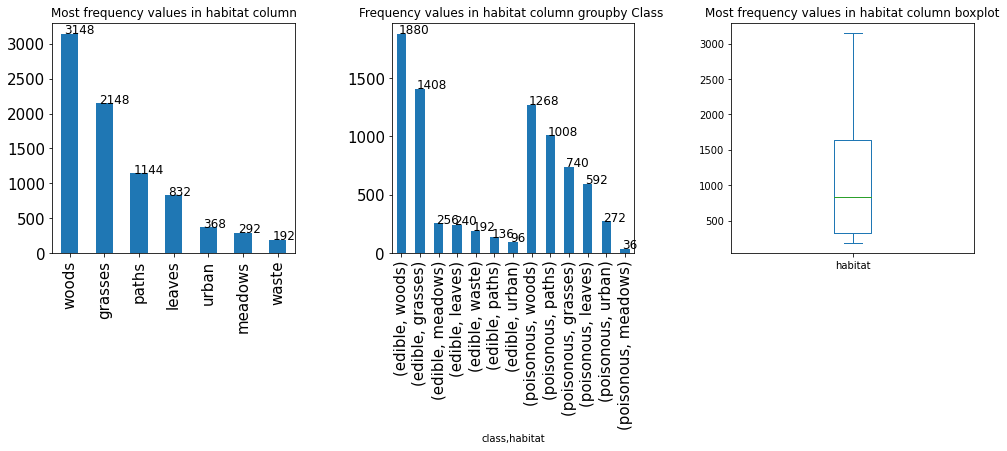

In [ ]:
plot_maker('habitat')

The wood is most frequency and waste is least frequency.<br/>
meadows and waste are all edible, but rest is enve distribute beteewn the two classes.